# Neural Networks and Deep Learning - Homework 1: Supervised Learning
## Classification Task
## Rosset Lorenzo, mat. 2021859

In [1]:
!git clone https://github.com/rossetl/NNDL.git
%cd NNDL/Homework\ 1

Cloning into 'NNDL'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 89 (delta 24), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (89/89), done.
/content/NNDL/Homework 1


In [2]:
from re import I
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from sklearn.model_selection import KFold

In [3]:
BATCHSIZE = 10
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.), (1.))]) # try to change this

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transform)

In [5]:
train_size = 7000
val_size = 3000
test_size = 3000

train_subset = SubsetRandomSampler(np.arange(train_size))
val_subset = SubsetRandomSampler(np.arange(train_size, train_size + val_size))
test_subset = SubsetRandomSampler(np.arange(test_size))

train_dataloader = DataLoader(train_dataset, sampler=train_subset, batch_size=BATCHSIZE, shuffle=False, num_workers=1)
val_dataloader = DataLoader(train_dataset, sampler=val_subset, batch_size=BATCHSIZE, shuffle=False, num_workers=1)
test_dataloader = DataLoader(test_dataset, sampler=test_subset, batch_size=1, shuffle=False, num_workers=1)

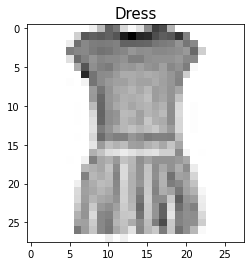

In [6]:
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def imshow(img, title):
    npimg = img.numpy()[0]
    plt.imshow(npimg, cmap='Greys')
    plt.title(title, size=15)
    plt.show()

idx = 3
imshow(train_dataset[idx][0], classes[train_dataset[idx][1]])

In [7]:
# Check that classes are evenly distributed across datasets
train_labels = np.array([])
val_labels = np.array([])
test_labels = np.array([])

for batch_sample in train_dataloader:
    labels = batch_sample[1].numpy()
    train_labels = np.append(train_labels, labels)

for batch_sample in val_dataloader:
    labels = batch_sample[1].numpy()
    val_labels = np.append(val_labels, labels)

for batch_sample in test_dataloader:
    labels = batch_sample[1].numpy()
    test_labels = np.append(test_labels, labels)

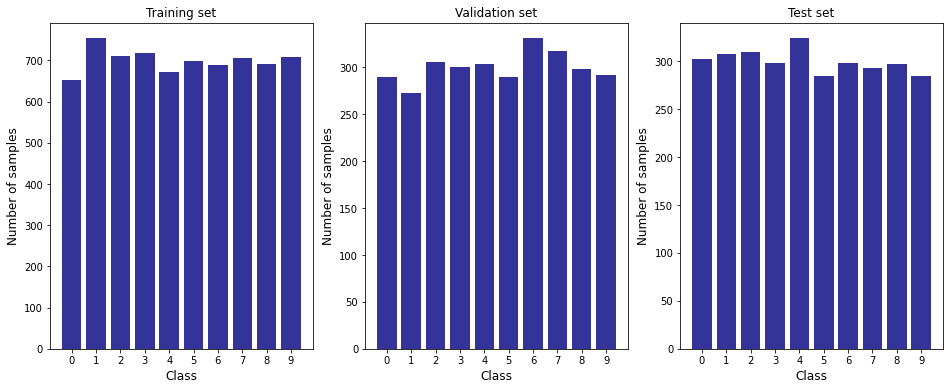

In [ ]:
fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=3)
titles = ['Training set', 'Validation set', 'Test set']
labels_list = [train_labels, val_labels, test_labels]
for title, ax, labels in zip(titles, axes, labels_list):
    ax.set_title(title, size=12)
    ax.set_xlabel('Class', size=12)
    ax.set_ylabel('Number of samples', size=12)
    ax.set_xticks(np.arange(10))
    ax.bar(*np.unique(labels, return_counts=True), color='navy', alpha=0.8);

## Simple Convolutional Network

In [ ]:
class Conv_net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(12*4*4, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
conv_net = Conv_net().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)

In [49]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss = []
    model.train()
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        out = model(x_batch)
        loss = loss_fn(out, label_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    return np.mean(train_loss)

def val_epoch(model, device, dataloader, loss_fn):
    val_loss = []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            out = model(x_batch)
            _, predicted = torch.max(out.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
            loss = loss_fn(out, label_batch)
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    accuracy = 100 * correct / total
    return np.mean(val_loss), accuracy

# Compute the accuracy over the test set
def compute_accuracy(model, device, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            out = model(x_batch)
            _, predicted = torch.max(out.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
num_epochs = 50
train_loss_log = []
val_loss_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(conv_net, DEVICE, train_dataloader, loss_fn, optimizer)
    train_loss_log.append(train_loss)

    val_loss, accuracy = val_epoch(conv_net, DEVICE, val_dataloader, loss_fn)
    val_loss_log.append(val_loss)

    print('Epoch {:}/{:}, avg train loss: {:.3f}, avg test loss: {:.3f}, accuracy: {:.3f}%'.format(epoch + 1, num_epochs, train_loss, val_loss, accuracy))

test_accuracy = compute_accuracy(conv_net, DEVICE, test_dataloader)

Epoch 1/50, avg train loss: 0.932, avg test loss: 0.670, accuracy: 74.000%
Epoch 2/50, avg train loss: 0.622, avg test loss: 0.620, accuracy: 76.000%
Epoch 3/50, avg train loss: 0.557, avg test loss: 0.545, accuracy: 77.000%
Epoch 4/50, avg train loss: 0.494, avg test loss: 0.518, accuracy: 80.000%
Epoch 5/50, avg train loss: 0.459, avg test loss: 0.508, accuracy: 81.000%
Epoch 6/50, avg train loss: 0.423, avg test loss: 0.500, accuracy: 80.000%
Epoch 7/50, avg train loss: 0.393, avg test loss: 0.455, accuracy: 84.000%
Epoch 8/50, avg train loss: 0.365, avg test loss: 0.465, accuracy: 83.000%
Epoch 9/50, avg train loss: 0.348, avg test loss: 0.424, accuracy: 84.000%
Epoch 10/50, avg train loss: 0.325, avg test loss: 0.448, accuracy: 83.000%
Epoch 11/50, avg train loss: 0.307, avg test loss: 0.471, accuracy: 83.000%
Epoch 12/50, avg train loss: 0.291, avg test loss: 0.476, accuracy: 83.000%
Epoch 13/50, avg train loss: 0.275, avg test loss: 0.450, accuracy: 84.000%
Epoch 14/50, avg trai

Accuracy over the test set: 84.767


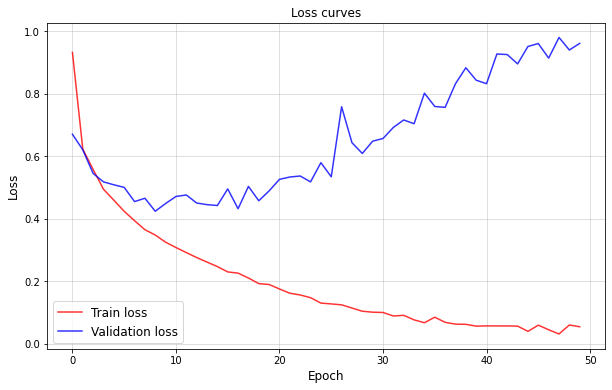

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_loss_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

print('Accuracy over the test set: {:.3f}'.format(test_accuracy))

## Different optimizers and sparsity

In [ ]:
optimizer_names = ['SGD', 'Adam', 'Adagrad', 'Adadelta', 'RMSprop']
train_curves = []
val_curves = []
test_losses = []
test_accuraces = []
for optimizer_name in optimizer_names:
    print('\n---------------------------')
    print('Optimizer:', optimizer_name)
    print('---------------------------\n')
    conv_net = Conv_net()
    conv_net.to(DEVICE)
    optimizer = getattr(optim, optimizer_name)(conv_net.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    num_epochs = 50
    train_loss_log = []
    val_loss_log = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(conv_net, DEVICE, train_dataloader, loss_fn, optimizer)
        train_loss_log.append(train_loss)

        val_loss, accuracy = val_epoch(conv_net, DEVICE, val_dataloader, loss_fn)
        val_loss_log.append(val_loss)

        print('Epoch {:}/{:}, avg train loss: {:.3f}, avg val loss: {:.3f}, accuracy: {:.3f}%'.format(epoch + 1, num_epochs, train_loss, val_loss, accuracy))

    test_accuracy = compute_accuracy(conv_net, DEVICE, test_dataloader)
    test_accuraces.append(test_accuracy)
    train_curves.append(train_loss_log)
    val_curves.append(val_loss_log)


---------------------------
Optimizer: SGD
---------------------------

Epoch 1/50, avg train loss: 2.307, avg val loss: 2.307, accuracy: 15.100%
Epoch 2/50, avg train loss: 2.303, avg val loss: 2.303, accuracy: 14.133%
Epoch 3/50, avg train loss: 2.299, avg val loss: 2.299, accuracy: 13.167%
Epoch 4/50, avg train loss: 2.294, avg val loss: 2.293, accuracy: 16.000%
Epoch 5/50, avg train loss: 2.286, avg val loss: 2.284, accuracy: 18.167%
Epoch 6/50, avg train loss: 2.275, avg val loss: 2.269, accuracy: 23.067%
Epoch 7/50, avg train loss: 2.254, avg val loss: 2.241, accuracy: 25.600%
Epoch 8/50, avg train loss: 2.211, avg val loss: 2.177, accuracy: 28.200%
Epoch 9/50, avg train loss: 2.092, avg val loss: 1.972, accuracy: 31.867%
Epoch 10/50, avg train loss: 1.721, avg val loss: 1.462, accuracy: 51.200%
Epoch 11/50, avg train loss: 1.267, avg val loss: 1.174, accuracy: 54.333%
Epoch 12/50, avg train loss: 1.089, avg val loss: 1.041, accuracy: 58.300%
Epoch 13/50, avg train loss: 1.027, 

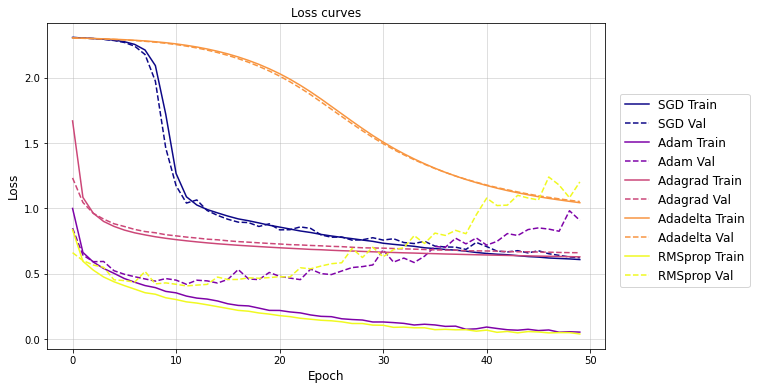

In [ ]:
# Visualization of training curves
colors = cm.get_cmap('plasma', len(optimizer_names))
plt.figure(figsize=(10,6))
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

for i, (train_curve, val_curve, label) in enumerate(zip(train_curves, val_curves, optimizer_names)):
    plt.plot(train_curve, c=colors(i), label=label + ' Train')
    plt.plot(val_curve, c=colors(i), ls='--', label=label + ' Val')

plt.legend(fontsize='12', bbox_to_anchor=(1.27, 0.8));

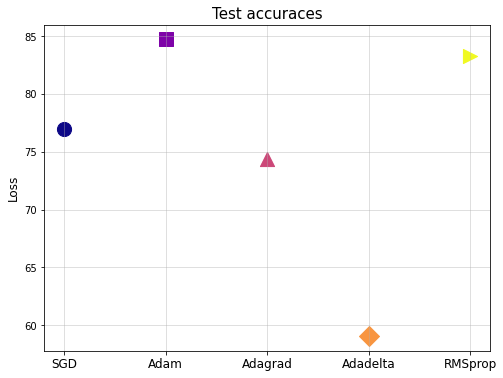

In [ ]:
# Visualization of performaces on the test set
plt.figure(figsize=(8,6))
plt.ylabel('Loss', size=12)
plt.title('Test accuraces', size=15)
plt.grid(axis='both', alpha=0.5)
markers = ['o', 's', '^', 'D', '>']

for i in range(len(optimizer_names)):
    plt.scatter([i], [test_accuraces[i]], s=200, color=colors(i), marker=markers[i])

plt.xticks(ticks=[0,1,2,3,4], labels=optimizer_names, rotation=0, size=12);

## Adding regularization and Hyperparameters Optimization

In [ ]:
%pip install optuna
import optuna

In [51]:
class Build_model(nn.Module):

    def __init__(self, params):
        super().__init__()
        
        assert np.any(np.array(params['kernel_size']) % 2 == 1), 'Kernel sizes must be odd!'
        
        # Convolutional layers
        conv_layers = []
        in_channels = 1
        for i in range(2):
            # define paddings so as to have always the same output shape
            padding = int((params['kernel_size'][i] - 1) / 2)
            conv_layers.append(nn.Conv2d(in_channels,
                                         params['out_channels'][i],
                                         params['kernel_size'][i],
                                         padding=padding))
            conv_layers.append(nn.Dropout2d(params['p_conv'][i]))
            conv_layers.append(nn.MaxPool2d(2, 2))
            conv_layers.append(nn.ReLU())
            in_channels = params['out_channels'][i]
        self.conv_layers = nn.Sequential(*conv_layers)

        # Fully connected layers
        fc_layers = []
        in_features = params['out_channels'][-1] * 7 * 7
        for i in range(2):
            fc_layers.append(nn.Linear(in_features, params['out_features'][i]))
            fc_layers.append(nn.Dropout(params['p_fc'][i]))
            fc_layers.append(nn.ReLU())
            in_features = params['out_features'][i]
        fc_layers.append(nn.Linear(in_features, 10))
        self.fc_layers = nn.Sequential(*fc_layers)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

def train_model(model, num_epochs, loss_fn, optimizer):
    train_loss_log = []
    val_loss_log = []
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, DEVICE, train_dataloader, loss_fn, optimizer)
        train_loss_log.append(train_loss)

        val_loss, accuracy = val_epoch(model, DEVICE, val_dataloader, loss_fn)
        val_loss_log.append(val_loss)

        print('Epoch {:}/{:}, avg train loss: {:.3f}, avg test loss: {:.3f}, accuracy: {:.3f}%'.format(epoch + 1, num_epochs, train_loss, val_loss, accuracy))
    return accuracy

def objective(trial):
    params = {
        'out_channels' : [trial.suggest_int('out_channels_conv0', 4, 6),
                          trial.suggest_int('out_channels_conv1', 4, 6)],
        'kernel_size' : [trial.suggest_int('kernel_size_conv0', 3, 7, step=2),
                         trial.suggest_int('kernel_size_conv1', 3, 7, step=2)],
        'p_conv' : [trial.suggest_float('dropout_conv0', 0., 0.5),
                    trial.suggest_float('dropout_conv1', 0., 0.5)],
        'out_features' : [trial.suggest_int('out_features_fc0', 100, 200),
                          trial.suggest_int('out_features_fc1', 30, 100)],
        'p_fc' : [trial.suggest_float('dropout_fc0', 0., 0.5),
                  trial.suggest_float('dropout_fc1', 0., 0.5)]
    }

    model = Build_model(params).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    accuracy = train_model(model, 10, loss_fn, optimizer)
    return accuracy


In [52]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

[I 2022-03-21 16:44:13,572] A new study created in memory with name: no-name-4d549f7e-a39c-4d03-88b6-2a459ed29c75


Epoch 1/10, avg train loss: 1.290, avg test loss: 0.779, accuracy: 68.833%
Epoch 2/10, avg train loss: 0.835, avg test loss: 0.654, accuracy: 75.033%
Epoch 3/10, avg train loss: 0.735, avg test loss: 0.616, accuracy: 75.867%
Epoch 4/10, avg train loss: 0.660, avg test loss: 0.547, accuracy: 80.633%
Epoch 5/10, avg train loss: 0.621, avg test loss: 0.527, accuracy: 80.200%
Epoch 6/10, avg train loss: 0.586, avg test loss: 0.523, accuracy: 79.700%
Epoch 7/10, avg train loss: 0.558, avg test loss: 0.472, accuracy: 82.300%
Epoch 8/10, avg train loss: 0.530, avg test loss: 0.452, accuracy: 83.467%
Epoch 9/10, avg train loss: 0.518, avg test loss: 0.486, accuracy: 82.333%


[I 2022-03-21 16:45:04,758] Trial 0 finished with value: 83.06666666666666 and parameters: {'out_channels_conv0': 6, 'out_channels_conv1': 5, 'kernel_size_conv0': 7, 'kernel_size_conv1': 7, 'dropout_conv0': 0.21681765340752385, 'dropout_conv1': 0.17502065991661303, 'out_features_fc0': 196, 'out_features_fc1': 59, 'dropout_fc0': 0.35677657349418723, 'dropout_fc1': 0.3977891581965502}. Best is trial 0 with value: 83.06666666666666.


Epoch 10/10, avg train loss: 0.484, avg test loss: 0.474, accuracy: 83.067%
Epoch 1/10, avg train loss: 1.346, avg test loss: 0.751, accuracy: 71.400%
Epoch 2/10, avg train loss: 0.887, avg test loss: 0.650, accuracy: 74.967%
Epoch 3/10, avg train loss: 0.767, avg test loss: 0.635, accuracy: 75.867%
Epoch 4/10, avg train loss: 0.729, avg test loss: 0.584, accuracy: 77.267%
Epoch 5/10, avg train loss: 0.701, avg test loss: 0.547, accuracy: 79.433%
Epoch 6/10, avg train loss: 0.668, avg test loss: 0.529, accuracy: 79.367%
Epoch 7/10, avg train loss: 0.644, avg test loss: 0.511, accuracy: 80.467%
Epoch 8/10, avg train loss: 0.607, avg test loss: 0.493, accuracy: 81.333%
Epoch 9/10, avg train loss: 0.605, avg test loss: 0.490, accuracy: 81.667%


[I 2022-03-21 16:45:55,808] Trial 1 finished with value: 82.46666666666667 and parameters: {'out_channels_conv0': 4, 'out_channels_conv1': 6, 'kernel_size_conv0': 5, 'kernel_size_conv1': 5, 'dropout_conv0': 0.2442733981241617, 'dropout_conv1': 0.49383074890340334, 'out_features_fc0': 177, 'out_features_fc1': 81, 'dropout_fc0': 0.2972717385567162, 'dropout_fc1': 0.30331077754474045}. Best is trial 0 with value: 83.06666666666666.


Epoch 10/10, avg train loss: 0.597, avg test loss: 0.471, accuracy: 82.467%
Epoch 1/10, avg train loss: 1.473, avg test loss: 0.916, accuracy: 62.167%
Epoch 2/10, avg train loss: 1.063, avg test loss: 0.778, accuracy: 67.167%
Epoch 3/10, avg train loss: 0.934, avg test loss: 0.686, accuracy: 73.367%
Epoch 4/10, avg train loss: 0.873, avg test loss: 0.640, accuracy: 74.867%
Epoch 5/10, avg train loss: 0.831, avg test loss: 0.603, accuracy: 76.233%
Epoch 6/10, avg train loss: 0.795, avg test loss: 0.575, accuracy: 78.700%
Epoch 7/10, avg train loss: 0.754, avg test loss: 0.570, accuracy: 76.300%
Epoch 8/10, avg train loss: 0.731, avg test loss: 0.553, accuracy: 78.367%
Epoch 9/10, avg train loss: 0.699, avg test loss: 0.523, accuracy: 78.767%


[I 2022-03-21 16:46:46,842] Trial 2 finished with value: 80.73333333333333 and parameters: {'out_channels_conv0': 5, 'out_channels_conv1': 4, 'kernel_size_conv0': 5, 'kernel_size_conv1': 7, 'dropout_conv0': 0.23543220640365758, 'dropout_conv1': 0.4938049185363511, 'out_features_fc0': 110, 'out_features_fc1': 49, 'dropout_fc0': 0.31782588486212077, 'dropout_fc1': 0.10811672218559132}. Best is trial 0 with value: 83.06666666666666.


Epoch 10/10, avg train loss: 0.694, avg test loss: 0.522, accuracy: 80.733%
Epoch 1/10, avg train loss: 1.461, avg test loss: 0.853, accuracy: 68.933%
Epoch 2/10, avg train loss: 1.018, avg test loss: 0.688, accuracy: 70.633%
Epoch 3/10, avg train loss: 0.895, avg test loss: 0.636, accuracy: 75.367%
Epoch 4/10, avg train loss: 0.814, avg test loss: 0.578, accuracy: 77.200%
Epoch 5/10, avg train loss: 0.798, avg test loss: 0.565, accuracy: 78.433%
Epoch 6/10, avg train loss: 0.750, avg test loss: 0.536, accuracy: 77.800%
Epoch 7/10, avg train loss: 0.730, avg test loss: 0.539, accuracy: 77.933%
Epoch 8/10, avg train loss: 0.716, avg test loss: 0.525, accuracy: 79.267%
Epoch 9/10, avg train loss: 0.696, avg test loss: 0.537, accuracy: 76.833%


[I 2022-03-21 16:47:38,029] Trial 3 finished with value: 80.5 and parameters: {'out_channels_conv0': 5, 'out_channels_conv1': 5, 'kernel_size_conv0': 7, 'kernel_size_conv1': 7, 'dropout_conv0': 0.39471578851215045, 'dropout_conv1': 0.4475986149152238, 'out_features_fc0': 101, 'out_features_fc1': 58, 'dropout_fc0': 0.4590346108048504, 'dropout_fc1': 0.015624715303734327}. Best is trial 0 with value: 83.06666666666666.


Epoch 10/10, avg train loss: 0.693, avg test loss: 0.506, accuracy: 80.500%
Epoch 1/10, avg train loss: 1.307, avg test loss: 0.842, accuracy: 68.233%
Epoch 2/10, avg train loss: 0.929, avg test loss: 0.724, accuracy: 70.000%
Epoch 3/10, avg train loss: 0.808, avg test loss: 0.655, accuracy: 75.533%
Epoch 4/10, avg train loss: 0.735, avg test loss: 0.611, accuracy: 77.067%
Epoch 5/10, avg train loss: 0.676, avg test loss: 0.589, accuracy: 78.567%
Epoch 6/10, avg train loss: 0.643, avg test loss: 0.539, accuracy: 80.100%
Epoch 7/10, avg train loss: 0.616, avg test loss: 0.546, accuracy: 79.333%
Epoch 8/10, avg train loss: 0.579, avg test loss: 0.507, accuracy: 80.133%
Epoch 9/10, avg train loss: 0.583, avg test loss: 0.520, accuracy: 80.367%


[I 2022-03-21 16:48:28,996] Trial 4 finished with value: 80.76666666666667 and parameters: {'out_channels_conv0': 4, 'out_channels_conv1': 5, 'kernel_size_conv0': 5, 'kernel_size_conv1': 3, 'dropout_conv0': 0.289152675732039, 'dropout_conv1': 0.32470921287714216, 'out_features_fc0': 149, 'out_features_fc1': 34, 'dropout_fc0': 0.0005985275201625395, 'dropout_fc1': 0.20768441528453158}. Best is trial 0 with value: 83.06666666666666.


Epoch 10/10, avg train loss: 0.549, avg test loss: 0.505, accuracy: 80.767%
Epoch 1/10, avg train loss: 1.426, avg test loss: 0.921, accuracy: 65.567%
Epoch 2/10, avg train loss: 1.041, avg test loss: 0.776, accuracy: 67.333%
Epoch 3/10, avg train loss: 0.944, avg test loss: 0.694, accuracy: 71.400%
Epoch 4/10, avg train loss: 0.850, avg test loss: 0.641, accuracy: 74.033%
Epoch 5/10, avg train loss: 0.803, avg test loss: 0.594, accuracy: 76.667%
Epoch 6/10, avg train loss: 0.770, avg test loss: 0.564, accuracy: 77.400%
Epoch 7/10, avg train loss: 0.720, avg test loss: 0.579, accuracy: 76.733%
Epoch 8/10, avg train loss: 0.706, avg test loss: 0.527, accuracy: 78.633%
Epoch 9/10, avg train loss: 0.695, avg test loss: 0.518, accuracy: 78.467%


[I 2022-03-21 16:49:20,190] Trial 5 finished with value: 81.0 and parameters: {'out_channels_conv0': 6, 'out_channels_conv1': 4, 'kernel_size_conv0': 7, 'kernel_size_conv1': 5, 'dropout_conv0': 0.2637778410877946, 'dropout_conv1': 0.47257175367780035, 'out_features_fc0': 109, 'out_features_fc1': 77, 'dropout_fc0': 0.07018663974430611, 'dropout_fc1': 0.4732590531278845}. Best is trial 0 with value: 83.06666666666666.


Epoch 10/10, avg train loss: 0.686, avg test loss: 0.514, accuracy: 81.000%
Epoch 1/10, avg train loss: 1.087, avg test loss: 0.650, accuracy: 73.533%
Epoch 2/10, avg train loss: 0.707, avg test loss: 0.589, accuracy: 76.033%
Epoch 3/10, avg train loss: 0.623, avg test loss: 0.540, accuracy: 78.767%
Epoch 4/10, avg train loss: 0.577, avg test loss: 0.485, accuracy: 81.600%
Epoch 5/10, avg train loss: 0.532, avg test loss: 0.461, accuracy: 83.700%
Epoch 6/10, avg train loss: 0.509, avg test loss: 0.455, accuracy: 84.100%
Epoch 7/10, avg train loss: 0.475, avg test loss: 0.433, accuracy: 83.467%
Epoch 8/10, avg train loss: 0.465, avg test loss: 0.430, accuracy: 84.300%
Epoch 9/10, avg train loss: 0.441, avg test loss: 0.414, accuracy: 84.767%


[I 2022-03-21 16:50:11,005] Trial 6 finished with value: 84.33333333333333 and parameters: {'out_channels_conv0': 4, 'out_channels_conv1': 6, 'kernel_size_conv0': 7, 'kernel_size_conv1': 3, 'dropout_conv0': 0.011441783196009081, 'dropout_conv1': 0.34631129444080816, 'out_features_fc0': 171, 'out_features_fc1': 91, 'dropout_fc0': 0.24272589369003672, 'dropout_fc1': 0.18366696578710479}. Best is trial 6 with value: 84.33333333333333.


Epoch 10/10, avg train loss: 0.433, avg test loss: 0.405, accuracy: 84.333%
Epoch 1/10, avg train loss: 1.036, avg test loss: 0.700, accuracy: 73.267%
Epoch 2/10, avg train loss: 0.689, avg test loss: 0.593, accuracy: 77.067%
Epoch 3/10, avg train loss: 0.600, avg test loss: 0.566, accuracy: 78.233%
Epoch 4/10, avg train loss: 0.543, avg test loss: 0.558, accuracy: 80.033%
Epoch 5/10, avg train loss: 0.509, avg test loss: 0.473, accuracy: 82.867%
Epoch 6/10, avg train loss: 0.478, avg test loss: 0.460, accuracy: 83.367%
Epoch 7/10, avg train loss: 0.450, avg test loss: 0.434, accuracy: 83.500%
Epoch 8/10, avg train loss: 0.421, avg test loss: 0.421, accuracy: 83.500%
Epoch 9/10, avg train loss: 0.409, avg test loss: 0.412, accuracy: 84.133%


[I 2022-03-21 16:51:01,867] Trial 7 finished with value: 84.03333333333333 and parameters: {'out_channels_conv0': 6, 'out_channels_conv1': 4, 'kernel_size_conv0': 7, 'kernel_size_conv1': 7, 'dropout_conv0': 0.039309312131127094, 'dropout_conv1': 0.19072603075305583, 'out_features_fc0': 181, 'out_features_fc1': 62, 'dropout_fc0': 0.049544396874326546, 'dropout_fc1': 0.15792451949862013}. Best is trial 6 with value: 84.33333333333333.


Epoch 10/10, avg train loss: 0.384, avg test loss: 0.413, accuracy: 84.033%
Epoch 1/10, avg train loss: 1.337, avg test loss: 0.763, accuracy: 70.500%
Epoch 2/10, avg train loss: 0.882, avg test loss: 0.660, accuracy: 74.200%
Epoch 3/10, avg train loss: 0.754, avg test loss: 0.588, accuracy: 76.967%
Epoch 4/10, avg train loss: 0.696, avg test loss: 0.561, accuracy: 76.533%
Epoch 5/10, avg train loss: 0.652, avg test loss: 0.556, accuracy: 77.000%
Epoch 6/10, avg train loss: 0.609, avg test loss: 0.532, accuracy: 78.800%
Epoch 7/10, avg train loss: 0.599, avg test loss: 0.513, accuracy: 78.600%
Epoch 8/10, avg train loss: 0.573, avg test loss: 0.510, accuracy: 79.400%
Epoch 9/10, avg train loss: 0.550, avg test loss: 0.488, accuracy: 81.367%


[I 2022-03-21 16:51:52,618] Trial 8 finished with value: 82.56666666666666 and parameters: {'out_channels_conv0': 4, 'out_channels_conv1': 6, 'kernel_size_conv0': 5, 'kernel_size_conv1': 3, 'dropout_conv0': 0.1402990041516438, 'dropout_conv1': 0.2731203051969701, 'out_features_fc0': 165, 'out_features_fc1': 39, 'dropout_fc0': 0.19132353217275805, 'dropout_fc1': 0.45327372296951907}. Best is trial 6 with value: 84.33333333333333.


Epoch 10/10, avg train loss: 0.530, avg test loss: 0.480, accuracy: 82.567%
Epoch 1/10, avg train loss: 1.277, avg test loss: 0.745, accuracy: 73.500%
Epoch 2/10, avg train loss: 0.806, avg test loss: 0.611, accuracy: 75.300%
Epoch 3/10, avg train loss: 0.704, avg test loss: 0.546, accuracy: 79.367%
Epoch 4/10, avg train loss: 0.650, avg test loss: 0.534, accuracy: 78.300%
Epoch 5/10, avg train loss: 0.611, avg test loss: 0.511, accuracy: 80.533%
Epoch 6/10, avg train loss: 0.587, avg test loss: 0.487, accuracy: 80.600%
Epoch 7/10, avg train loss: 0.576, avg test loss: 0.476, accuracy: 81.133%
Epoch 8/10, avg train loss: 0.531, avg test loss: 0.463, accuracy: 82.233%
Epoch 9/10, avg train loss: 0.530, avg test loss: 0.453, accuracy: 83.233%


[I 2022-03-21 16:52:43,178] Trial 9 finished with value: 83.03333333333333 and parameters: {'out_channels_conv0': 5, 'out_channels_conv1': 4, 'kernel_size_conv0': 3, 'kernel_size_conv1': 3, 'dropout_conv0': 0.23488103762998658, 'dropout_conv1': 0.12350146820577901, 'out_features_fc0': 124, 'out_features_fc1': 39, 'dropout_fc0': 0.10249156385602515, 'dropout_fc1': 0.39307281030098756}. Best is trial 6 with value: 84.33333333333333.


Epoch 10/10, avg train loss: 0.506, avg test loss: 0.434, accuracy: 83.033%


In [57]:
study.best_params

{'dropout_conv0': 0.011441783196009081,
 'dropout_conv1': 0.34631129444080816,
 'dropout_fc0': 0.24272589369003672,
 'dropout_fc1': 0.18366696578710479,
 'kernel_size_conv0': 7,
 'kernel_size_conv1': 3,
 'out_channels_conv0': 4,
 'out_channels_conv1': 6,
 'out_features_fc0': 171,
 'out_features_fc1': 91}

In [54]:
from torch.nn.modules import padding
class Best_conv_net(nn.Module):

    def __init__(self, params):
        super().__init__()
        padding0 = int((params['kernel_size_conv0'] - 1) / 2)
        padding1 = int((params['kernel_size_conv1'] - 1) / 2)
        conv_layers = []
        conv_layers.append(nn.Conv2d(in_channels=1,
                               out_channels=params['out_channels_conv0'],
                               kernel_size=params['kernel_size_conv0'],
                               padding=padding0))
        conv_layers.append(nn.Dropout2d(params['dropout_conv0']))
        conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.Conv2d(in_channels=params['out_channels_conv1'],
                               out_channels=params['out_channels_conv1'],
                               kernel_size=params['kernel_size_conv1'],
                               padding=padding1))
        conv_layers.append(nn.Dropout2d(params['dropout_conv1']))
        conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        conv_layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*conv_layers)

        fc_layers = []
        fc_layers.append(nn.Linear(params['out_channels_conv1']*7*7,
                             params['out_features_fc0']))
        fc_layers.append(nn.Dropout(params['dropout_fc0']))
        fc_layers.append(nn.ReLU())
        fc_layers.append(nn.Linear(params['out_features_fc0'],
                             params['out_features_fc1']))
        fc_layers.append(nn.Dropout(params['dropout_fc1']))
        fc_layers.append(nn.ReLU())
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

### Learning rate and sparsity

In [58]:
def optim_objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    sparsity = trial.suggest_float('sparsity', 1e-5, 2e-1, log=True)
    
    best_conv_net = Best_conv_net(study.best_params).to(DEVICE)
    optimizer = optim.Adam(best_conv_net.parameters(), lr=lr, weight_decay=sparsity)
    loss_fn = nn.CrossEntropyLoss()
    accuracy = train_model(best_conv_net, 10, loss_fn, optimizer)
    return accuracy

In [59]:
optim_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
optim_study.optimize(optim_objective, n_trials=10)

[I 2022-03-21 16:55:28,345] A new study created in memory with name: no-name-affcc445-627f-4304-8692-a2c19533531a
[W 2022-03-21 16:55:28,463] Trial 0 failed because of the following error: RuntimeError('Given groups=1, weight of size [6, 6, 3, 3], expected input[10, 4, 14, 14] to have 6 channels, but got 4 channels instead')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-58-3b5aae50b4ad>", line 8, in optim_objective
    accuracy = train_model(best_conv_net, 10, loss_fn, optimizer)
  File "<ipython-input-51-fe7d297d4f28>", line 45, in train_model
    train_loss = train_epoch(model, DEVICE, train_dataloader, loss_fn, optimizer)
  File "<ipython-input-49-18e960ceddf9>", line 7, in train_epoch
    out = model(x_batch)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input,

RuntimeError: ignored

In [ ]:
optim_study.best_params

{'lr': 0.0009905268022381316, 'sparsity': 0.0013893865004386099}

In [ ]:
best_conv_net = Best_conv_net(study.best_params).to(DEVICE)
optimizer = optim.Adam(best_conv_net.parameters(), lr=optim_study.best_params['lr'], weight_decay=optim_study.best_params['sparsity'])
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50
train_loss_log = []
val_loss_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(best_conv_net, DEVICE, train_dataloader, loss_fn, optimizer)
    train_loss_log.append(train_loss)

    val_loss, accuracy = val_epoch(best_conv_net, DEVICE, val_dataloader, loss_fn)
    val_loss_log.append(val_loss)

    print('Epoch {:}/{:}, avg train loss: {:.3f}, avg test loss: {:.3f}, accuracy: {:.3f}%'.format(epoch + 1, num_epochs, train_loss, val_loss, accuracy))

test_accuracy = compute_accuracy(best_conv_net, DEVICE, test_dataloader)

Epoch 1/50, avg train loss: 3.567, avg test loss: 2.678, accuracy: 51.700%
Epoch 2/50, avg train loss: 3.076, avg test loss: 2.229, accuracy: 59.700%
Epoch 3/50, avg train loss: 2.720, avg test loss: 2.120, accuracy: 60.133%
Epoch 4/50, avg train loss: 2.679, avg test loss: 2.036, accuracy: 61.333%
Epoch 5/50, avg train loss: 2.664, avg test loss: 1.812, accuracy: 63.767%
Epoch 6/50, avg train loss: 2.618, avg test loss: 1.769, accuracy: 64.600%
Epoch 7/50, avg train loss: 2.600, avg test loss: 1.844, accuracy: 64.900%
Epoch 8/50, avg train loss: 2.543, avg test loss: 1.692, accuracy: 66.367%
Epoch 9/50, avg train loss: 2.543, avg test loss: 1.905, accuracy: 65.633%
Epoch 10/50, avg train loss: 2.519, avg test loss: 1.693, accuracy: 65.133%
Epoch 11/50, avg train loss: 2.471, avg test loss: 1.693, accuracy: 67.067%
Epoch 12/50, avg train loss: 2.238, avg test loss: 0.936, accuracy: 82.000%
Epoch 13/50, avg train loss: 1.993, avg test loss: 0.945, accuracy: 81.233%
Epoch 14/50, avg trai

Accuracy over the test set: 85.567


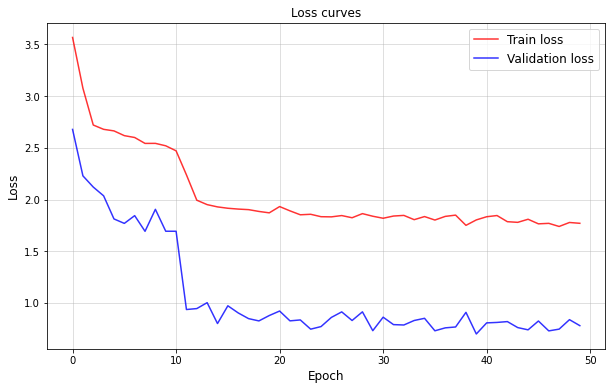

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_loss_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

print('Accuracy over the test set: {:.3f}'.format(test_accuracy))

In [ ]:
torch.save(best_conv_net.state_dict(), 'best_conv_net_params.pt')

In [9]:
best_params = {
    'dropout_conv0': 0.02131434311129221,
    'dropout_conv1': 0.07204307322560044,
    'dropout_fc0': 0.14055985014470335,
    'dropout_fc1': 0.31072867438449076,
    'kernel_size_conv0': 3,
    'kernel_size_conv1': 5,
    'out_channels_conv0': 5,
    'out_channels_conv1': 5,
    'out_features_fc0': 54,
    'out_features_fc1': 98
    }

In [10]:
best_conv_net = Best_conv_net(best_params).to(DEVICE)
best_conv_net.load_state_dict(torch.load('saved_models/best_conv_net_params.pt'))

<All keys matched successfully>

## Visualization of feature maps

In [11]:
def show_feature_maps(model, data_index):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.conv_layers[0].register_forward_hook(get_activation('conv1'))
    model.conv_layers[4].register_forward_hook(get_activation('conv2'))
    data, _ = train_dataset[data_index]
    data.unsqueeze_(0)
    output = model(data.to(DEVICE))

    act1 = activation['conv1'].squeeze()
    fig1, ax1 = plt.subplots(figsize=(3*len(act1), 3), nrows=1, ncols=len(act1))
    fig1.suptitle('First convolutional layer', size=16)
    for image, ax in zip(act1, ax1):
        ax.imshow(image.cpu(), cmap='Greys')

    act2 = activation['conv2'].squeeze()
    fig1, ax2 = plt.subplots(figsize=(3*len(act2), 3), nrows=1, ncols=len(act2))
    fig1.suptitle('Second convolutional layer', size=16)
    for image, ax in zip(act2, ax2):
        ax.imshow(image.cpu(), cmap='Greys')

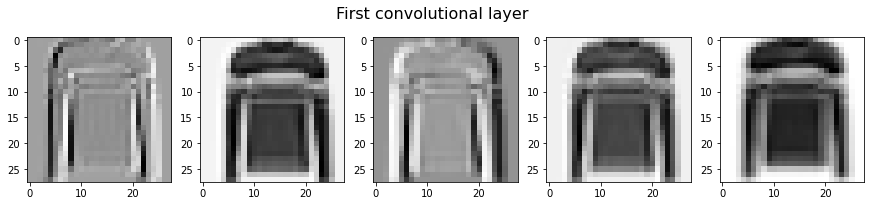

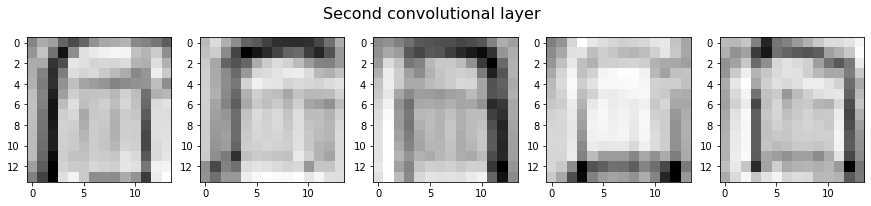

In [12]:
show_feature_maps(best_conv_net, 5)

In [43]:
def show_activation_maps(model, data_index):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = torch.sigmoid(output).detach()
        return hook

    model.fc_layers[0].register_forward_hook(get_activation('fc1'))
    model.fc_layers[3].register_forward_hook(get_activation('fc2'))
    data, _ = train_dataset[data_index]
    data.unsqueeze_(0)
    output = model(data.to(DEVICE))

    act1 = activation['fc1'].squeeze()
    fig, ax = plt.subplots(figsize=(12,7), nrows=2, ncols=1)
    ax[0].set_title('Activations fc layer 1', size=12)
    ax[0].stem(act1.cpu(), markerfmt='C3o');

    act2 = activation['fc2'].squeeze()
    ax[1].set_title('Activations fc layer 2', size=12)
    ax[1].stem(act2.cpu(), markerfmt='C3o');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


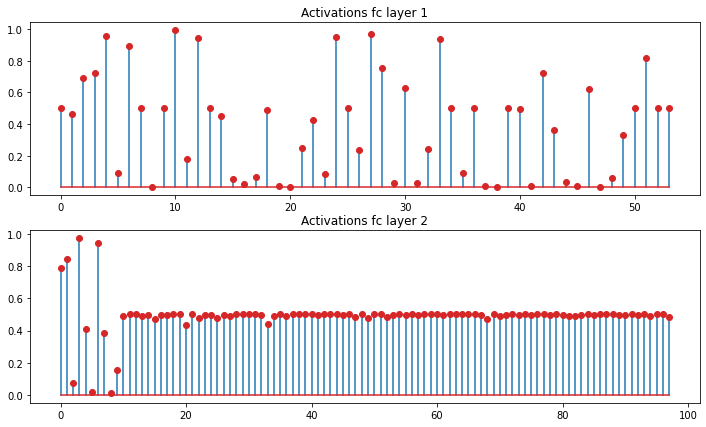

In [44]:
show_activation_maps(best_conv_net, 4)